Checking folder: logs_PPO_Masked_WITH_HISTORY_42_20250824_175332
PPO_1 directory exists: True
Event files found: 1
Available scalar tags (45 total):
  - episode/base_step_penalty
  - episode/eta_penalty
  - episode/frequency_reward
  - episode/fuel_penalty
  - episode/length
  - episode/pair_selected/0a38028e
  - episode/pair_selected/299514f5
  - episode/pair_selected/8d4892ba
  - episode/pair_selected/94f05a54
  - episode/pair_selected/a3064c2c
  ... and 35 more


Found ablations: ['logs_PPO_Masked_WITH_HISTORY', 'logs_PPO_HISTORY', 'logs_PPO_Masked_no_positive', 'logs_PPO', 'logs_PPO_Masked_RND', 'logs_PPO_Masked', 'logs_PPO_RND']

Processing logs_PPO_Masked_WITH_HISTORY...
Available tags: ['episode/base_step_penalty', 'episode/eta_penalty', 'episode/frequency_reward', 'episode/fuel_penalty', 'episode/length', 'episode/pair_selected/0a38028e', 'episode/pair_selected/299514f5', 'episode/pair_selected/8d4892ba', 'episode/pair_selected/94f05a54', 'episode/pair_selected/a3064c2c', 'epis

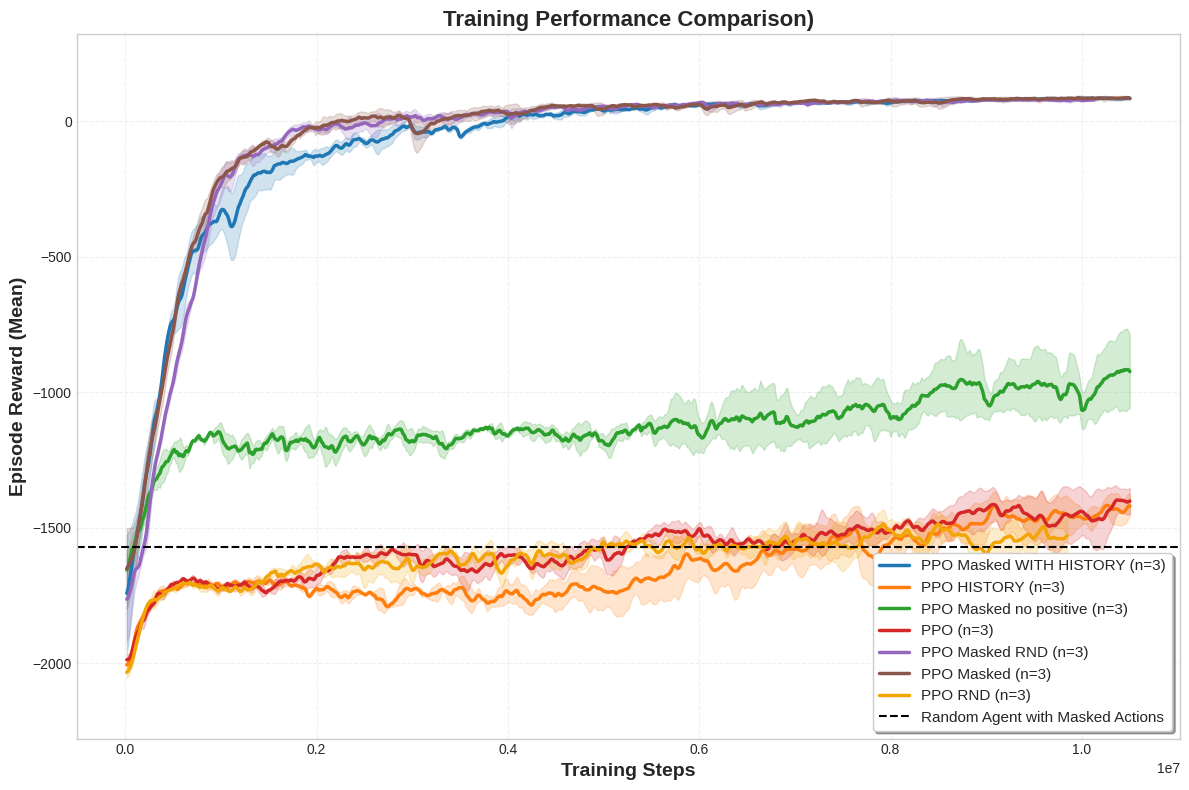

In [3]:
import os
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator


# Configuration
LOGS_DIR = 'logs'
SCALAR_TAG = 'rollout/ep_rew_mean'  # Change this if needed
METHOD_NAME_MAPPING = {
    "PPO": "PPO (no mask)",
    "PPO Masked": "Masked PPO",
    "PPO RND": "PPO RND (no mask)",
    "PPO Masked RND": "Masked PPO RND",
    "PPO HISTORY": "PPO with History (no mask)",
    "PPO Masked WITH HISTORY": "Masked PPO with History",
}


# Set up publication-ready plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")


def exponential_moving_average(data, smoothing_factor=0.9):
    """Compute exponential moving average similar to Tensorboard."""
    alpha = 1 - smoothing_factor
    smoothed = np.zeros_like(data, dtype=float)
    smoothed[0] = data[0]  # Fixed: First point remains the same

    for i in range(1, len(data)):
        smoothed[i] = alpha * data[i] + (1 - alpha) * smoothed[i - 1]

    return smoothed


def extract_scalar_from_tb(log_dir, tag):
    """Extract scalar data from tensorboard log directory"""
    # Look for event files in the PPO_1 subdirectory
    event_files = glob.glob(os.path.join(log_dir, "PPO_1", "events.out.tfevents.*"))
    
    if not event_files:
        print(f"No event files found in {log_dir}/PPO_1/")
        return None, None
    
    try:
        ea = EventAccumulator(event_files[0])
        ea.Reload()
        
        available_tags = ea.Tags().get('scalars', [])
        if tag not in available_tags:
            print(f"Tag '{tag}' not found in {log_dir}")
            print(f"Available tags: {available_tags[:5]}...")  # Show first 5 tags
            return None, None

        print(f"Available tags: {available_tags}")

        if "rollout/episode_reward_mean" in available_tags:
            print("Using 'rollout/episode_reward_mean' instead of 'rollout/ep_rew_mean'")
            tag = "rollout/episode_reward_mean"

        events = ea.Scalars(tag)
        steps = np.array([e.step for e in events])
        vals = np.array([e.value for e in events])
        return steps, vals
    except Exception as e:
        print(f"Error reading {log_dir}: {e}")
        return None, None


def debug_first_folder():
    """Debug function to see what's in the first folder"""
    folders = [f for f in os.listdir(LOGS_DIR) if os.path.isdir(os.path.join(LOGS_DIR, f))]
    
    if folders:
        first_folder = folders[0]
        full_path = os.path.join(LOGS_DIR, first_folder)
        ppo_path = os.path.join(full_path, "PPO_1")
        
        print(f"Checking folder: {first_folder}")
        print(f"PPO_1 directory exists: {os.path.exists(ppo_path)}")
        
        if os.path.exists(ppo_path):
            event_files = glob.glob(os.path.join(ppo_path, "events.out.tfevents.*"))
            print(f"Event files found: {len(event_files)}")
            
            if event_files:
                try:
                    ea = EventAccumulator(event_files[0])
                    ea.Reload()
                    scalars = ea.Tags().get('scalars', [])
                    print(f"Available scalar tags ({len(scalars)} total):")
                    for tag in scalars[:10]:  # Show first 10 tags
                        print(f"  - {tag}")
                    if len(scalars) > 10:
                        print(f"  ... and {len(scalars) - 10} more")
                except Exception as e:
                    print(f"Error reading event file: {e}")


def get_ablation_base(folder):
    """Extract ablation name by removing seed and timestamp"""
    return re.sub(r"_[0-9]+_[0-9]{8}_[0-9]{6}$", "", folder)


def create_neurips_plot(smoothing_factor=0.9):
    """Create publication-ready plot for NeurIPS paper with exponential moving average"""
    
    # First debug what's available
    debug_first_folder()
    print("\n" + "="*50 + "\n")
    
    # Get all log directories
    if not os.path.exists(LOGS_DIR):
        print(f"Logs directory {LOGS_DIR} not found!")
        return
        
    folders = [f for f in os.listdir(LOGS_DIR) if os.path.isdir(os.path.join(LOGS_DIR, f))]
    
    # Group folders by ablation
    ablations = {}
    for folder in folders:
        if "RANDOM" in folder:
            continue
        base = get_ablation_base(folder)
        ablations.setdefault(base, []).append(folder)
    
    print(f"Found ablations: {list(ablations.keys())}")
    
    # Create figure
    plt.figure(figsize=(12, 8))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#F3A505']
    
    plot_count = 0
    
    for i, (ablation_name, runs) in enumerate(ablations.items()):
        print(f"\nProcessing {ablation_name}...")
        all_steps = []
        all_vals = []
        
        for run in runs:
            full_path = os.path.join(LOGS_DIR, run)
            steps, vals = extract_scalar_from_tb(full_path, SCALAR_TAG)
            
            if steps is not None and vals is not None:
                all_steps.append(steps)
                all_vals.append(vals)
                print(f"  ✓ {run}: {len(vals)} data points")
            else:
                print(f"  ✗ {run}: No data found")
        
        if all_vals:
            # Find common step range
            min_steps = max(steps[0] for steps in all_steps)
            max_steps = min(steps[-1] for steps in all_steps)
            
            if max_steps > min_steps:
                common_steps = np.linspace(min_steps, max_steps, 1000)
                
                # Interpolate all runs to common step grid and apply EMA
                smoothed_vals = []
                for steps, vals in zip(all_steps, all_vals):
                    # First interpolate to common steps
                    interp_vals = np.interp(common_steps, steps, vals)
                    # Then apply exponential moving average
                    smoothed_interp_vals = exponential_moving_average(interp_vals, smoothing_factor)
                    smoothed_vals.append(smoothed_interp_vals)
                
                # Calculate statistics on smoothed data
                mean_vals = np.mean(smoothed_vals, axis=0)
                std_vals = np.std(smoothed_vals, axis=0)
                
                # Clean up ablation name for legend
                clean_name = ablation_name.replace('logs_', '').replace('_', ' ')
                
                # Plot with error bands
                color = colors[i % len(colors)]
                plt.plot(common_steps, mean_vals, 
                        label=f'{clean_name} (n={len(all_vals)})', 
                        linewidth=2.5, 
                        color=color)
                plt.fill_between(common_steps, 
                               mean_vals - std_vals, 
                               mean_vals + std_vals, 
                               alpha=0.2, 
                               color=color)
                
                plot_count += 1
                print(f"  ✓ Plotted with {len(all_vals)} seeds (EMA smoothing: {smoothing_factor})")
            else:
                print(f"  ✗ Invalid step range: {min_steps} to {max_steps}")
        else:
            print(f"  ✗ No valid data for {ablation_name}")
    
    # Plot dashed line for score of random agent (-1570.7)
    plt.axhline(y=-1570.7, color='black', linestyle='--', label='Random Agent with Masked Actions')

    if plot_count > 0:
        # Format plot for publication
        plt.xlabel('Training Steps', fontsize=14, fontweight='bold')
        plt.ylabel('Episode Reward (Mean)', fontsize=14, fontweight='bold')
        plt.title('Training Performance Comparison)', fontsize=16, fontweight='bold')
        plt.legend(fontsize=11, loc='lower right', frameon=True, fancybox=True, shadow=True)
        plt.grid(True, alpha=0.3, linestyle='--')
        plt.tight_layout()
        
        # Add some padding to y-axis
        ymin, ymax = plt.ylim()
        plt.ylim(ymin - (ymax-ymin)*0.05, ymax + (ymax-ymin)*0.05)
        
        # Save high-resolution figures
        plt.savefig('neurips_reward_comparison_ema.png', dpi=300, bbox_inches='tight', 
                    facecolor='white', edgecolor='none')
        plt.savefig('neurips_reward_comparison_ema.pdf', dpi=300, bbox_inches='tight',
                    facecolor='white', edgecolor='none')
        
        print(f"\n✓ Successfully created plot with {plot_count} ablations!")
        print("✓ Saved: neurips_reward_comparison_ema.png and neurips_reward_comparison_ema.pdf")
        print(f"✓ Applied exponential moving average with smoothing factor: {smoothing_factor}")
        
        plt.show()
    else:
        print("\n✗ No data could be plotted.")
        print("Check if 'rollout/ep_rew_mean' is the correct scalar tag name.")


if __name__ == "__main__":
    # You can adjust the smoothing factor (0.9 is default, higher = more smoothing)
    create_neurips_plot(smoothing_factor=0.9)

In [2]:
# Calculate average episodic return for logs/logs_PPO_MASKED_RANDOM
log_dir = 'logs/logs_PPO_MASKED_RANDOM'
steps, vals = extract_scalar_from_tb(log_dir, SCALAR_TAG)

if steps is not None and vals is not None:
    avg_return = np.mean(vals)
    print(f"Average episodic return for {log_dir}: {avg_return}")

Average episodic return for logs/logs_PPO_MASKED_RANDOM: -1570.706267069995
